In [16]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score

from scipy.stats import chi2_contingency

#from preprocess import extra_features, separate
from pipelines import pipe, pipe2, extra_features

In [3]:
train=pd.read_csv('../Datasets/train.csv')

In [67]:
#train.drop(columns= ['trip_length', 'group_size','total_male', 'total_female'], inplace=True)
X=train.drop('cost_category', axis=1)
X.set_index('Tour_ID', inplace=True)

In [68]:
X.shape

(18506, 19)

In [69]:
#d = pd.DataFrame(X['purpose'])
#from sklearn.feature_extraction import DictVectorizer
#vec = DictVectorizer(sparse=False, separator='=')
#D = [{'foo': 1, 'bar': 2}, {'foo': 3, 'baz': 1}]
#X = vec.fit_transform(D)
#X
#dd = vec.fit_transform(D)

In [70]:
X = pipe(X)
X.shape

(18506, 57)

In [71]:
y= train['cost_category']
y.shape

le=LabelEncoder()
y=le.fit_transform(y).astype('int')
y

array([0, 0, 1, ..., 1, 1, 3])

In [72]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
y_test.shape

(3702,)

In [9]:
X_test

array([[-0.3693954 , -0.97797934,  1.50882672, ..., -0.43473819,
        -0.47270314, -1.4272617 ],
       [-0.3693954 ,  1.02251648, -0.66276663, ...,  0.41469501,
        -0.47270314,  0.98663933],
       [-0.3693954 ,  1.02251648, -0.66276663, ...,  0.34390891,
        -0.47270314,  1.01077834],
       ...,
       [ 2.70712631, -0.97797934, -0.66276663, ..., -0.36395209,
        -0.47270314, -1.57209577],
       [-0.3693954 ,  1.02251648, -0.66276663, ..., -0.64709649,
         0.85430759, -0.67895238],
       [-0.3693954 ,  1.02251648, -0.66276663, ..., -0.29316599,
         0.09601574,  0.60041516]])

In [73]:
import warnings
warnings.filterwarnings('ignore')

params={'objective':'multiclass',
        'hist':'tree',
        'early_stopping_rounds':50,
       'verbose':100}

model= XGBClassifier(n_estimators=800,
                     objective='multiclass',
                     tree_method = 'hist',
                     booster='gbtree',
                     max_depth=8,
                     reg_lambda=10,
                     learning_rate=0.01,
                     subsample=0.63,
                     verbosity=1,
                     )

#model.fit(X_train, y_train)

In [18]:
preds = model.predict_proba(X_test)

print(roc_auc_score(y_test, preds, multi_class='ovr'))

0.8455632810173447


In [19]:
y_pred=model.predict(X_test)
model.score(X_test, y_test)

0.5713128038897893

In [20]:
print(classification_report(y_test, y_pred, target_names=le.classes_ ) )

              precision    recall  f1-score   support

   High Cost       0.49      0.35      0.40       736
 Higher Cost       0.63      0.77      0.69       973
Highest Cost       0.12      0.01      0.02        72
    Low Cost       0.37      0.04      0.06       313
  Lower Cost       0.60      0.66      0.63       514
 Normal Cost       0.55      0.69      0.61      1094

    accuracy                           0.57      3702
   macro avg       0.46      0.42      0.40      3702
weighted avg       0.54      0.57      0.54      3702



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

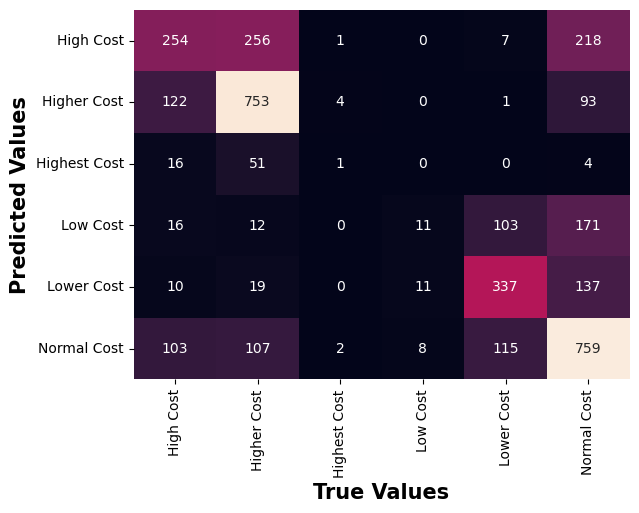

In [21]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
           xticklabels=le.classes_,
           yticklabels=le.classes_)
plt.xlabel('True Values', size=15, weight='bold')
plt.ylabel('Predicted Values', weight='bold', size=15)
plt.show();

In [76]:
kfold=StratifiedKFold(n_splits=10, shuffle=True)

In [77]:
for fold, (train_idx, val_idx) in enumerate(kfold.split(X,y)):
    X_train, X_test= X[train_idx], X[val_idx]
    y_train, y_test = y[train_idx], y[val_idx]

In [78]:
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

[0]	validation_0-mlogloss:1.78359
[100]	validation_0-mlogloss:1.35699
[200]	validation_0-mlogloss:1.21260
[300]	validation_0-mlogloss:1.15407
[400]	validation_0-mlogloss:1.12851
[500]	validation_0-mlogloss:1.11610
[600]	validation_0-mlogloss:1.11013
[700]	validation_0-mlogloss:1.10772
[799]	validation_0-mlogloss:1.10716


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [79]:
y_pred=model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.47      0.36      0.41       367
 Higher Cost       0.65      0.75      0.69       487
Highest Cost       0.43      0.08      0.14        36
    Low Cost       0.13      0.01      0.02       156
  Lower Cost       0.57      0.58      0.58       257
 Normal Cost       0.53      0.70      0.61       547

    accuracy                           0.56      1850
   macro avg       0.46      0.42      0.41      1850
weighted avg       0.52      0.56      0.53      1850



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

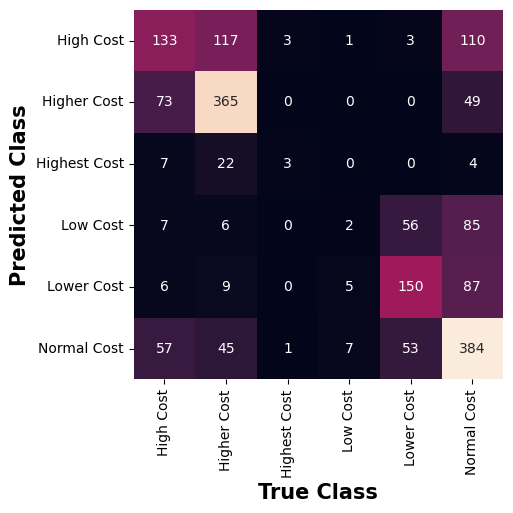

In [80]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', square=True, cbar=False,
           xticklabels=le.classes_,
           yticklabels=le.classes_)
plt.xlabel('True Class', weight='bold', size=15)
plt.ylabel('Predicted Class', weight='bold', size=15)
plt.show();

In [81]:
preds = model.predict_proba(X_test)
roc_auc_score(y_test, preds, multi_class='ovo')

0.8372887198614671

In [82]:
model.score(X_train, y_train)

0.6648054755043228

In [83]:
model.score(X_test, y_test)

0.5605405405405406

In [66]:
X_test.shape

(1850, 57)

In [65]:
import os
import pickle

dire = os.path.dirname('.')
pickle.dump(model,
           open(os.path.join(dire, 'FlaskApp', 'pickle_objects', 'xgboost.pkl'), 'wb'))

In [31]:
prob = pd.DataFrame(model.predict_proba(X_test).round(4), columns=le.classes_)
prob['Actual Category'] = le.inverse_transform(y_test)
prob

,High Cost,Higher Cost,Highest Cost,Low Cost,Lower Cost,Normal Cost,Actual Category
0,0.1826,0.6592,0.0513,0.0203,0.0220,0.0646,Higher Cost
1,0.0561,0.0326,0.0037,0.1366,0.0834,0.6875,Low Cost
2,0.3373,0.4485,0.0312,0.0117,0.0296,0.1418,High Cost
3,0.0697,0.0292,0.0041,0.2013,0.2246,0.4711,Low Cost
4,0.0219,0.0109,0.0029,0.1660,0.0832,0.7151,Normal Cost
...,...,...,...,...,...,...,...
1845,0.0143,0.0093,0.0033,0.2111,0.4015,0.3604,Low Cost
1846,0.0267,0.0096,0.0043,0.2425,0.4464,0.2706,Low Cost
1847,0.3087,0.1268,0.0042,0.0618,0.0661,0.4324,High Cost
1848,0.2000,0.6438,0.0562,0.0117,0.0122,0.0762,Higher Cost


In [44]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.5702702702702702

In [45]:
weights = []
for i in zip (y_train, le.classes_):
    w = 1/np.bincount(y_train)*1000
    weights.append(w)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
weights

[array([0.30202356, 0.2284148 , 3.09597523, 0.70921986, 0.43290043,
        0.20308692]),
 array([0.30202356, 0.2284148 , 3.09597523, 0.70921986, 0.43290043,
        0.20308692]),
 array([0.30202356, 0.2284148 , 3.09597523, 0.70921986, 0.43290043,
        0.20308692]),
 array([0.30202356, 0.2284148 , 3.09597523, 0.70921986, 0.43290043,
        0.20308692]),
 array([0.30202356, 0.2284148 , 3.09597523, 0.70921986, 0.43290043,
        0.20308692]),
 array([0.30202356, 0.2284148 , 3.09597523, 0.70921986, 0.43290043,
        0.20308692])]

In [53]:
from sklearn.neural_network import MLPClassifier
nn=MLPClassifier(hidden_layer_sizes=(32,64,128,256))
nn.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(32, 64, 128, 256))

In [54]:
nn.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.49      0.34      0.40       367
 Higher Cost       0.61      0.76      0.68       487
Highest Cost       0.00      0.00      0.00        36
    Low Cost       0.35      0.04      0.08       156
  Lower Cost       0.62      0.61      0.61       257
 Normal Cost       0.55      0.73      0.63       547

    accuracy                           0.57      1850
   macro avg       0.44      0.41      0.40      1850
weighted avg       0.54      0.57      0.54      1850



In [56]:
preds = nn.predict_proba(X_test)
roc_auc_score(y_test, preds, multi_class='ovo')

0.7333082251447354

In [57]:
sc = pd.Series(model.get_booster().get_score(importance_type='gain'))
sc.ravel()


array([ 1.16014481,  0.85608059,  1.05271149,  1.67593253,  1.02472126,
        5.12966061,  0.66334164,  0.97241265,  1.124668  ,  1.17218792,
        0.97892392, 10.39045906,  0.66040349,  1.13105822,  1.0020262 ,
        0.82190162,  1.14115703,  0.73367029,  0.77694875,  0.61677349,
        0.60756397,  1.05346894,  0.89638728,  0.82257342,  0.89853781,
        0.77037579,  1.08048618,  0.83829516,  0.7731685 ,  0.82789171,
        0.6816591 ,  0.73360574,  0.6951713 ,  0.82289451,  0.74077529,
        0.76357216, 45.98334122,  2.28780985,  3.89815497,  1.18722355,
        0.99910396,  0.95750314,  1.06471467,  0.76930118,  0.7442252 ,
        1.35767186,  1.40227473,  1.20159757])

In [59]:
pipe2??

In [58]:
importances = model.feature_importances_

feat_labels = train.columns
indices = np.argsort(importances)[::-1]


for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
           importances[indices],
           align='center')
plt.xticks(range(X_train.shape[1]),
          feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.show();

<IPython.core.display.Javascript object>

IndexError: index 36 is out of bounds for axis 0 with size 21

In [60]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features,
                scoring=accuracy_score, 
                test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, 
                                                            random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                X_test, y_test, self.indices_)
        
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim - 1):
                score =self._calc_score(X_train, y_train,
                                       X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
        
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [61]:
sbs = SBS(model, k_features=10)
sbs.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of Features')
plt.grid()
plt.tight_layout()
plt.show();

In [24]:
model.get_booster().get_score(importance_type='gain')

{'f0': 1.5088201761245728,
 'f1': 1.0198912620544434,
 'f2': 1.3202826976776123,
 'f3': 3.0646023750305176,
 'f4': 1.0347559452056885,
 'f5': 6.7453413009643555,
 'f6': 0.9376354217529297,
 'f7': 1.389347791671753,
 'f8': 1.4034308195114136,
 'f9': 1.4103949069976807,
 'f10': 1.062185525894165,
 'f11': 13.065668106079102,
 'f12': 0.4589858949184418,
 'f13': 1.418103575706482,
 'f14': 1.4834568500518799,
 'f15': 2.1083083152770996,
 'f16': 1.4512224197387695,
 'f17': 1.1150977611541748,
 'f18': 0.9846895337104797,
 'f19': 0.7835997939109802,
 'f20': 1.0198088884353638,
 'f21': 1.2645177841186523,
 'f22': 1.1093679666519165,
 'f23': 0.8650566339492798,
 'f24': 0.8839313387870789,
 'f25': 0.9952889680862427,
 'f26': 1.6135352849960327,
 'f27': 0.9210712909698486,
 'f28': 0.847886323928833,
 'f29': 0.9289758801460266,
 'f30': 1.087989091873169,
 'f31': 1.0952409505844116,
 'f32': 1.1916992664337158,
 'f33': 1.0335522890090942,
 'f34': 0.9451335072517395,
 'f35': 53.30481719970703,
 'f37': 

In [25]:
X.shape

(18506, 187)

<IPython.core.display.Javascript object>

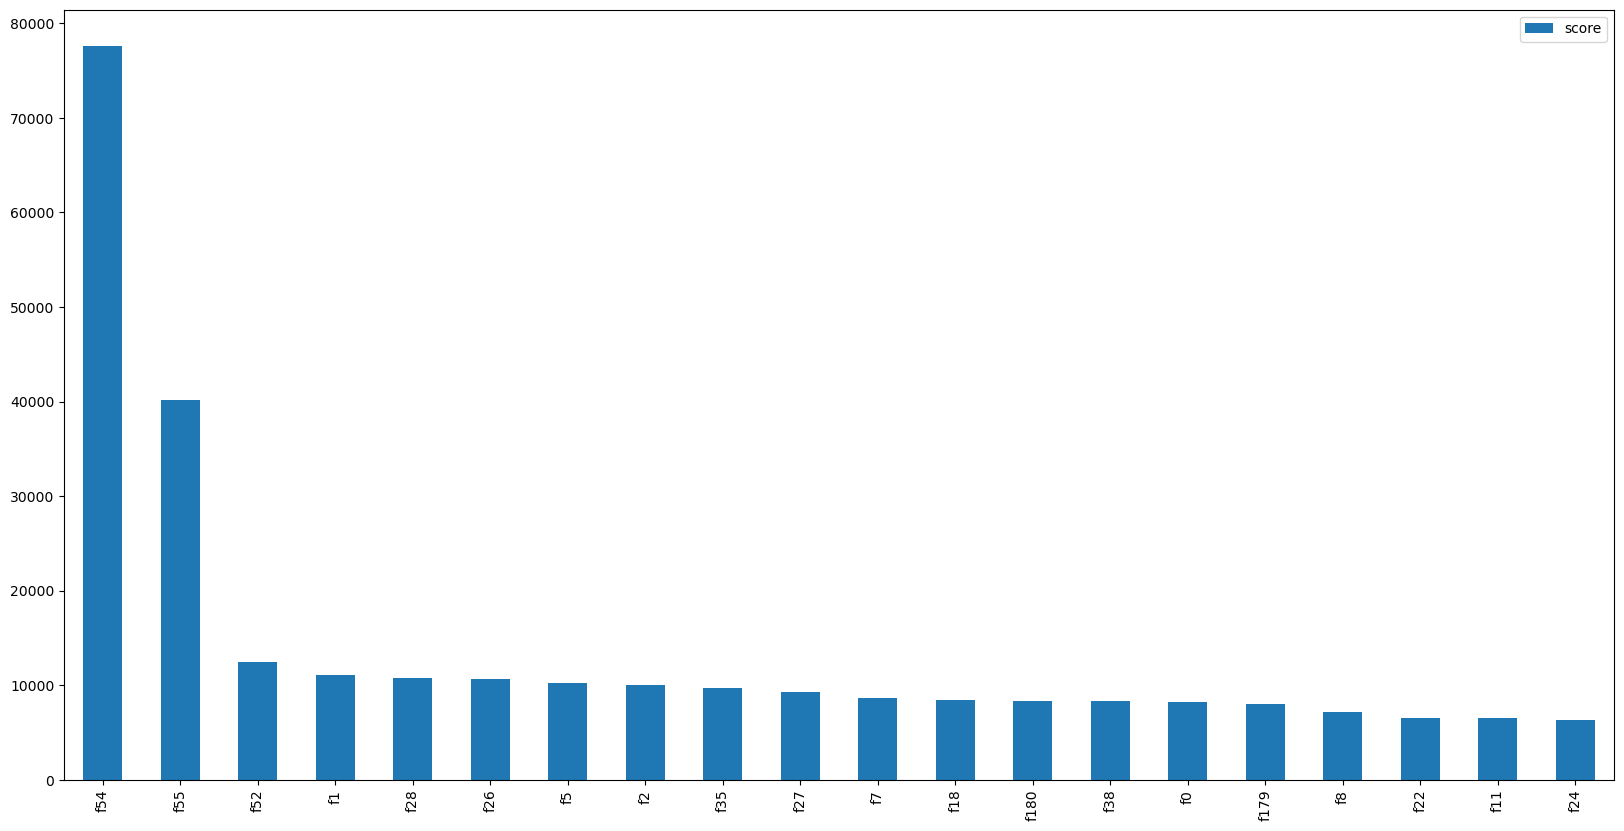

In [29]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.nlargest(20, columns="score").plot(kind='bar', figsize = (20,10)); ## plot top 20 features

<IPython.core.display.Javascript object>

     feature  importance
45      f54     77578.0
46      f55     40211.0
44      f52     12485.0
1        f1     11089.0
28      f28     10747.0
..      ...         ...
68     f103         2.0
110    f177         1.0
77     f125         1.0
54      f75         1.0
98     f159         1.0

[117 rows x 2 columns]


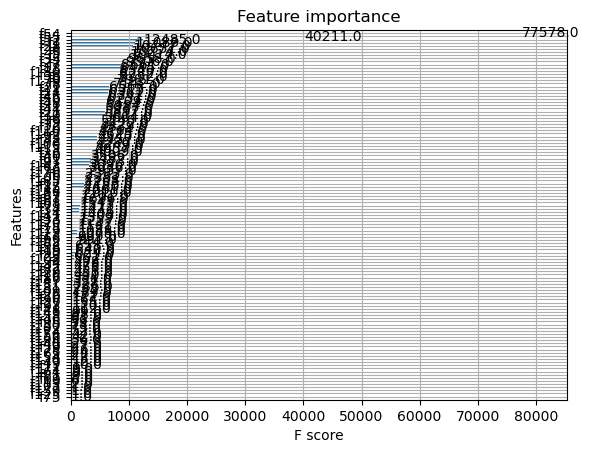

In [32]:
xgb_fea_imp=pd.DataFrame(list(model.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)
xgb_fea_imp.to_csv('xgb_fea_imp.csv')

from xgboost import plot_importance
plot_importance(model);

In [33]:
pipe.transformers_

AttributeError: 'function' object has no attribute 'transformers_'